# **Amazon Lookout for Equipment** - SDK Tutorial

#### Temporary cell to be executed until module is published on PyPI:

In [1]:
!pip install --quiet --use-feature=in-tree-build ..

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Initialization
---

### Imports

In [18]:
import boto3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import sagemaker
import sys

from lookoutequipment import plot, dataset, model, evaluation, scheduler

### Parameters

<span style="color: white; background-color: OrangeRed; padding: 0px 15px 0px 15px; border-radius: 20px;">**Note:** Update the value of the **bucket** and **prefix** variables below **before** running the following cell</span>

Make sure the IAM role used to run your notebook has access to the chosen bucket.

In [5]:
bucket   = '<<YOUR-BUCKET>>'
prefix   = '<<YOUR_PREFIX>>/' # Keep the trailing slash at the end

plt.style.use('Solarize_Light2')
plt.rcParams['lines.linewidth'] = 0.5

### Dataset preparation

In [6]:
data = dataset.load_dataset(dataset_name='expander', target_dir='expander-data')
dataset.upload_dataset('expander-data', bucket, prefix)

Component subsystem-17: 100%|██████████| 24/24 [02:23<00:00,  5.97s/it]


## Role definition
--- 
Before you can run this notebook (for instance, from a SageMaker environment), you will need:
* To allow SageMaker to run Lookout for Equipment API calls
* To allow Amazon Lookout for Equipment to access your training data (located in the bucket and prefix defined in the previous cell)

### Authorizing SageMaker to make Lookout for Equipment calls
You need to ensure that this notebook instance has an IAM role which allows it to call the Amazon Lookout for Equipment APIs:

1. In your IAM console, look for the SageMaker execution role endorsed by your notebook instance (a role with a name like `AmazonSageMaker-ExecutionRole-yyyymmddTHHMMSS`)
2. On the `Permissions` tab, click on `Attach policies`
3. In the Filter policies search field, look for `AmazonLookoutEquipmentFullAccess`, tick the checkbox next to it and click on `Attach policy`
4. Browse to the `Trust relationship` tab for this role, click on the `Edit trust relationship` button and fill in the following policy. You may already have a trust relationship in place for this role, in this case, just add the **"lookoutequipment.amazonaws.com"** in the service list:

```json
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": [
          "sagemaker.amazonaws.com",
            
          // ... Other services
            
          "lookoutequipment.amazonaws.com"
        ]
      },
      "Action": "sts:AssumeRole"
    }
  ]
}
```

5. Click on `Update the Trust Policy`: your SageMaker notebook instance can now call the Lookout for Equipment APIs

### Give access to your S3 data to Lookout for Equipment
When Lookout for Equipment will run, it will try to access your S3 data at several occasions:

* When ingesting the training data
* At training time when accessing the label data
* At inference time to run the input data and output the results

To enable these access, you need to create a role that Lookout for Equipment can endorse by following these steps:

1. Log in again to your [**IAM console**](https://console.aws.amazon.com/iamv2/home)
2. On the left menu bar click on `Roles` and then on the `Create role` button located at the top right
3. On the create role screen, selected `AWS Service` as the type of trusted entity
4. In the following section (`Choose a use case`), locate `SageMaker` and click on the service name. Not all AWS services appear in these ready to configure use cases and this is why we are using SageMaker as the baseline for our new role. In the next steps, we will adjust the role created to configure it specifically for Amazon Lookout for Equipment.
5. Click on the `Next` button until you reach the last step (`Review`): give a name and a description to your role (for instance `LookoutEquipmentS3AccessRole`)
6. Click on `Create role`: your role is created and you are brought back to the list of existing role
7. In the search bar, search for the role you just created and choose it from the returned result to see a summary of your role
8. At the top of your screen, you will see a role ARN field: **copy this ARN and paste it in the following cell, replacing the `<<YOUR_ROLE_ARN>>` string below**
9. Click on the cross at the far right of the `AmazonSageMakerFullAccess` managed policy to remove this permission for this role as we don't need it.
10. Click on `Add inline policy` and then on the `JSON` tab. Then fill in the policy with the following document (update the name of the bucket with the one you created earlier):

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:ListBucket",
                "s3:GetObject"
            ],
            "Resource": [
                "arn:aws:s3:::<<YOUR-BUCKET>>/*",
                "arn:aws:s3:::<<YOUR-BUCKET>>"
            ]
        }
    ]
}
```
10. Give a name to your policy (for instance: `LookoutEquipmentS3AccessPolicy`) and click on `Create policy`.
11. On the `Trust relationships` tab, choose `Edit trust relationship`.
12. Under policy document, replace the whole policy by the following document and click on the `Update Trust Policy` button on the bottom right:

```json
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "",
      "Effect": "Allow",
      "Principal": {
        "Service": "lookoutequipment.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}
```

And you're done! When Amazon Lookout for Equipment will try to read the datasets you just uploaded in S3, it will request permissions from IAM by using the role we just created:
1. The **trust policy** allows Lookout for Equipment to assume this role.
2. The **inline policy** specifies that Lookout for Equipment is authorized to list and access the objects in the S3 bucket you created earlier.

<span style="color: white; background-color: OrangeRed; padding: 0px 15px 0px 15px; border-radius: 20px;">Don't forget to update the **role_arn** variable below with the ARN of the role you just create **before** running the following cell</span>

In [ ]:
role_arn = '<<YOUR_ROLE_ARN>>'

## Lookout for Equipment end-to-end walkthrough
---

### Dataset creation and data ingestion

In [8]:
lookout_dataset = dataset.LookoutEquipmentDataset(
    dataset_name='my_dataset',
    access_role_arn=role_arn,
    component_root_dir=f's3://{bucket}/{prefix}training-data'
)
lookout_dataset.create()
response = lookout_dataset.ingest_data(bucket, prefix + 'training-data/', wait=True)

Dataset "my_dataset" does not exist, creating it...

2021-09-03 06:59:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:00:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:01:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:02:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:03:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:04:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:05:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:06:53 | Data ingestion: IN_PROGRESS
2021-09-03 07:07:53 | Data ingestion: SUCCESS


### Building an anomaly detection model
#### Model training

In [9]:
lookout_model = model.LookoutEquipmentModel(model_name='my_model', 
                                            dataset_name='my_dataset')
lookout_model.set_time_periods(data['evaluation_start'],
                               data['evaluation_end'],
                               data['training_start'],
                               data['training_end'])
lookout_model.set_label_data(bucket=bucket, 
                             prefix=prefix + 'label-data/',
                             access_role_arn=role_arn)
lookout_model.set_target_sampling_rate(sampling_rate='PT5M')
response = lookout_model.train()
lookout_model.poll_model_training(sleep_time=300)

2021-09-03 07:32:19 | Model training: IN_PROGRESS
2021-09-03 07:37:19 | Model training: IN_PROGRESS
2021-09-03 07:42:20 | Model training: IN_PROGRESS
2021-09-03 07:47:20 | Model training: IN_PROGRESS
2021-09-03 07:52:20 | Model training: IN_PROGRESS
2021-09-03 07:57:20 | Model training: IN_PROGRESS
2021-09-03 08:02:21 | Model training: IN_PROGRESS
2021-09-03 08:07:21 | Model training: IN_PROGRESS
2021-09-03 08:12:21 | Model training: IN_PROGRESS
2021-09-03 08:17:21 | Model training: IN_PROGRESS
2021-09-03 08:22:22 | Model training: SUCCESS


#### Trained model evaluation overview

In [12]:
LookoutDiagnostics = evaluation.LookoutEquipmentAnalysis(model_name='my_model', tags_df=data['data'])
predicted_ranges = LookoutDiagnostics.get_predictions()
labels_fname = os.path.join('expander-data', 'labels.csv')
labeled_range = LookoutDiagnostics.get_labels(labels_fname)

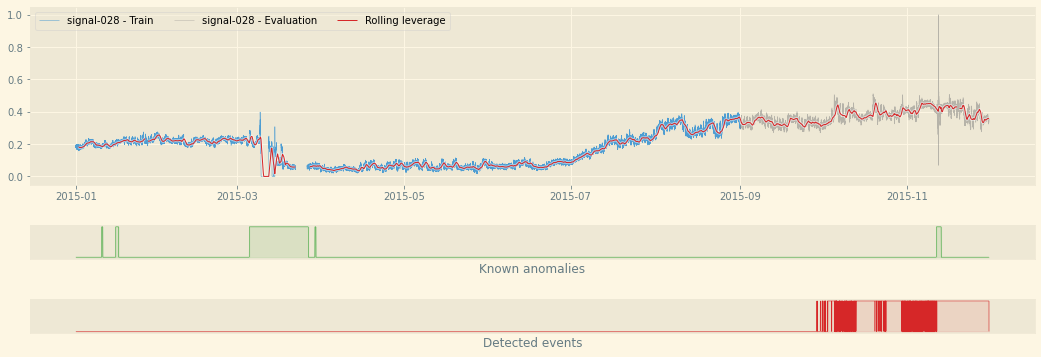

In [13]:
TSViz = plot.TimeSeriesVisualization(timeseries_df=data['data'], data_format='tabular')
TSViz.add_signal(['signal-028'])
TSViz.add_labels(labeled_range)
TSViz.add_predictions([predicted_ranges])
TSViz.add_train_test_split(data['evaluation_start'])
TSViz.add_rolling_average(60*24)
TSViz.legend_format = {'loc': 'upper left', 'framealpha': 0.4, 'ncol': 3}
fig, axis = TSViz.plot()

### Scheduling inferences
#### Preparing inferencing data

In [14]:
dataset.prepare_inference_data(
    root_dir='expander-data',
    sample_data_dict=data,
    bucket=bucket,
    prefix=prefix,
    start_date='2015-11-21 04:00:00',
    num_sequences=12
)

Extracting data from 2015-11-21 04:00:00 to 2015-11-21 04:04:00
Extracting data from 2015-11-21 04:05:00 to 2015-11-21 04:09:00
Extracting data from 2015-11-21 04:10:00 to 2015-11-21 04:14:00
Extracting data from 2015-11-21 04:15:00 to 2015-11-21 04:19:00
Extracting data from 2015-11-21 04:20:00 to 2015-11-21 04:24:00
Extracting data from 2015-11-21 04:25:00 to 2015-11-21 04:29:00
Extracting data from 2015-11-21 04:30:00 to 2015-11-21 04:34:00
Extracting data from 2015-11-21 04:35:00 to 2015-11-21 04:39:00
Extracting data from 2015-11-21 04:40:00 to 2015-11-21 04:44:00
Extracting data from 2015-11-21 04:45:00 to 2015-11-21 04:49:00
Extracting data from 2015-11-21 04:50:00 to 2015-11-21 04:54:00
Extracting data from 2015-11-21 04:55:00 to 2015-11-21 04:59:00


#### Configuring and starting a scheduler

In [15]:
lookout_scheduler = scheduler.LookoutEquipmentScheduler(
    scheduler_name='my_scheduler',
    model_name='my_model'
)

scheduler_params = {
    'input_bucket': bucket,
    'input_prefix': prefix + 'inference-data/input/',
    'output_bucket': bucket,
    'output_prefix': prefix + 'inference-data/output/',
    'role_arn': role_arn,
    'upload_frequency': 'PT5M',
    'delay_offset': None,
    'timezone_offset': '+00:00',
    'component_delimiter': '_',
    'timestamp_format': 'yyyyMMddHHmmss'
}

lookout_scheduler.set_parameters(**scheduler_params)
response = lookout_scheduler.create()

===== Polling Inference Scheduler Status =====

Scheduler Status: PENDING
Scheduler Status: RUNNING

===== End of Polling Inference Scheduler Status =====


#### Post-processing the inference results

In [16]:
results_df = lookout_scheduler.get_predictions()
results_df.head()

,prediction,subsystem-01\signal-026,subsystem-01\signal-027,subsystem-01\signal-028,subsystem-01\signal-029,subsystem-01\signal-040,subsystem-01\signal-041,subsystem-01\signal-055,subsystem-01\signal-056,subsystem-01\signal-068,...,subsystem-15\signal-089,subsystem-16\signal-090,subsystem-17\signal-108,subsystem-18\signal-099,subsystem-19\signal-067,subsystem-20\signal-076,subsystem-21\signal-084,subsystem-22\signal-097,subsystem-23\signal-098,subsystem-24\signal-083
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-03 09:35:00,1,0.0,0.0,0.02,0.04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


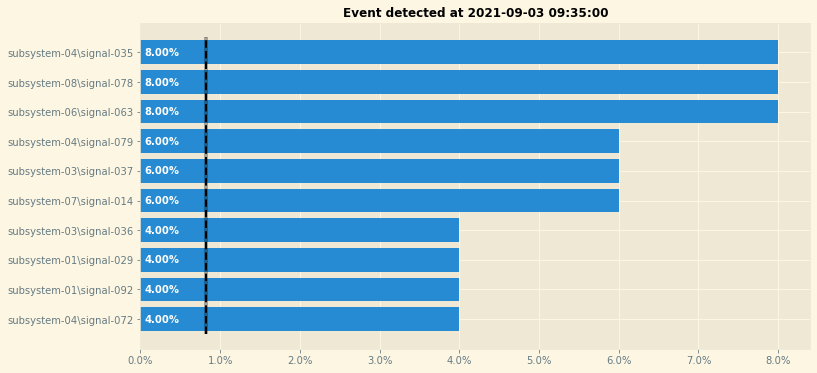

In [19]:
event_details = pd.DataFrame(results_df.iloc[0, 1:]).reset_index()
fig, ax = plot.plot_event_barh(event_details, fig_width=12)